# Piecewise polynomial regression

Inspired by the example in
> Fearnhead, Paul, and Zhen Liu. "Efficient Bayesian analysis of multiple changepoint models with dependence across segments." Statistics and Computing 21 (2011): 217-229.


In [52]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## The choice of (M.1)

In [4]:
import chex
import einops
import distrax
from jax.flatten_util import ravel_pytree
from rebayes_mini.states import GaussState
from rebayes_mini.methods.adaptive import Runlength
from rebayes_mini.methods.gauss_filter import ExtendedKalmanFilter

In [5]:
@chex.dataclass
class BOCDPGaussState:
    """
    State for a
    Bayesian online changepoint detection with position (BOCDP)
    with Gaussian posterior
    """
    mean: chex.Array
    cov: chex.Array
    log_joint: chex.Array
    runlength: chex.Array
    last_x: chex.Array



@chex.dataclass
class SBOCDPGaussState:
    """
    State for a
    Bayesian online changepoint detection with position (BOCDP)
    with Gaussian posterior
    """
    mean: chex.Array
    cov: chex.Array
    log_joint: chex.Array
    runlength: chex.Array
    last_x: chex.Array
    log_posterior: chex.Array

In [6]:
class ExtendedKalmanFilterFeatures:
    def __init__(
        self, fn_latent, fn_obs, dynamics_covariance, observation_covariance,
    ):
        self.fn_latent = fn_latent
        self.fn_obs = fn_obs
        self.dynamics_covariance = dynamics_covariance
        self.observation_covariance = observation_covariance

    def _initalise_vector_fns(self, latent):
        vlatent, rfn = ravel_pytree(latent)

        @jax.jit # ht(z)
        def vobs_fn(latent, x, params):
            latent = rfn(latent)
            return self.fn_obs(latent, x, params)

        @jax.jit # ft(z, u)
        def vlatent_fn(latent):
            return self.fn_latent(latent)

        return rfn, vlatent_fn, vobs_fn, vlatent

    def _init_components(self, mean, cov):
        self.rfn, self.vlatent_fn, self.vobs_fn, vlatent = self._initalise_vector_fns(mean)
        self.jac_latent = jax.jacrev(self.vlatent_fn) # Ft
        self.jac_obs = jax.jacrev(self.vobs_fn) # Ht
        dim_latent = len(vlatent)

        cov = jnp.eye(dim_latent) * cov
        return vlatent, cov, dim_latent

    def init_bel(self, mean, cov=1.0):
        mean, cov, dim_latent = self._init_components(mean, cov)

        return GaussState(
            mean=mean,
            cov=cov,
        )

    def _predict(self, bel):
        Ft = self.jac_latent(bel.mean)
        mean_pred = self.vlatent_fn(bel.mean)
        cov_pred = Ft @ bel.cov @ Ft.T + self.dynamics_covariance
        bel = bel.replace(mean=mean_pred, cov=cov_pred)
        return bel

    def _update(self, bel, y, x):
        Ht = self.jac_obs(bel.mean, x, bel)
        Rt = self.observation_covariance

        St = Ht @ bel.cov @ Ht.T + Rt
        Kt = jnp.linalg.solve(St, Ht @ bel.cov).T

        err = y - self.vobs_fn(bel.mean, x, bel)
        mean_update = bel.mean + Kt @ err
        cov_update = bel.cov - Kt @ St @ Kt.T

        bel = bel.replace(mean=mean_update, cov=cov_update)
        return bel

    def step(self, bel, xs, callback_fn):
        xt, yt = xs
        bel_pred = self._predict(bel)
        bel_update = self._update(bel_pred, yt, xt, bel_pred)

        output = callback_fn(bel_update, bel_pred, yt, xt)
        return bel_update, output

    def scan(self, bel, y, X, callback_fn=None):
        xs = (X, y)
        callback_fn = callbacks.get_null if callback_fn is None else callback_fn
        _step = partial(self.step, callback_fn=callback_fn)
        import pdb; pdb.set_trace()
        bels, hist = jax.lax.scan(_step, bel, xs)
        return bels, hist

In [7]:
class PiecewiseRLPR(Runlength):
    """
    Runlength prior reset (RL-PR)
    """
    def __init__(
            self, p_change, K, filter, moment_match=True
    ):
        super().__init__(p_change, K)
        self.filter = filter
        self.moment_match = moment_match

    def init_bel(self, mean, cov, log_joint_init, x_init):
        state_filter = self.filter.init_bel(mean, cov)
        mean = state_filter.mean
        cov = state_filter.cov

        bel = BOCDPGaussState(
                mean=einops.repeat(mean, "i -> k i", k=self.K),
                cov=einops.repeat(cov, "i j -> k i j", k=self.K),
                log_joint=(jnp.ones((self.K,)) * -jnp.inf).at[0].set(log_joint_init),
                runlength=jnp.zeros(self.K),
                last_x=jnp.ones(self.K) * x_init
        )

        return bel

    def update_bel(self, y, X, bel):
        bel_pred = self.filter._predict(bel)
        bel = self.filter._update(bel_pred, y, X)
        return bel
    

    def log_predictive_density(self, y, X, bel):
        """
        compute the log-posterior predictive density
        of the moment-matched Gaussian
        """
        mean  = self.filter.vobs_fn(bel.mean, X, bel).astype(float)
        Rt = self.filter.observation_covariance
        Ht = self.filter.jac_obs(bel.mean, X, bel)
        covariance = Ht @ bel.cov @ Ht.T + Rt
        mean = jnp.atleast_1d(mean)
        log_p_pred = distrax.MultivariateNormalFullCovariance(mean, covariance).log_prob(y)
        return log_p_pred

    def update_bel(self, y, X, bel):
        bel_pred = self.filter._predict(bel)
        bel = self.filter._update(bel_pred, y, X)
        return bel


    def moment_match_prior(self, y, X, bel, bel_prior):
        """
        Moment-match the first two moments of the prior at time $t$.
        """
        weights_prior = bel.log_joint - jax.nn.logsumexp(bel.log_joint)
        weights_prior = jnp.exp(weights_prior) * self.p_change
        bel_hat = jax.vmap(self.update_bel, in_axes=(None, None, 0))(y, X, bel)
        mean_prior = jnp.einsum("k,kd->d", weights_prior, bel_hat.mean)
        
        # Building covariance
        E2 = bel_hat.cov + jnp.einsum("ki,kj->kij", bel_hat.mean, bel_hat.mean)
        cov_prior = (
            jnp.einsum("k,kij->ij", weights_prior, E2) -
            jnp.einsum("i,j->ij", mean_prior, mean_prior)
        )
        
        bel_prior = bel_prior.replace(
            mean=mean_prior,
            cov=cov_prior,
            # update the first value in the new sequence to be the current value
            last_x=jnp.squeeze(X)
        )
        return bel_prior

    
    def step(self, y, X, bel, bel_prior, callback_fn):
        """
        Update belief state and log-joint for a single observation
        """
        bel_prior = jax.lax.cond(
            self.moment_match,
            lambda: self.moment_match_prior(y, X, bel, bel_prior),
            lambda: bel_prior,
        )
        
        log_joint, top_indices = self.update_log_joint(y, X, bel, bel_prior)
        bel_posterior = self.update_bel_indices(y, X, bel, bel_prior, top_indices)

        bel_posterior = self.update_runlengths(bel_posterior, top_indices)
        bel_posterior = bel_posterior.replace(log_joint=log_joint)
    
        out = callback_fn(bel_posterior, bel, y, X, top_indices)
        return bel_posterior, out

In [8]:
class SoftPiecewiseRLPR(Runlength):
    """
    Greedy runlength with prior reset (RL-PR)
    """
    def __init__(
            self, p_change, filter, deflate_mean, threshold=1/2, shock=1.0
    ):
        super().__init__(p_change, K=1)
        self.filter = filter
        self.deflate_mean = deflate_mean
        self.shock = shock
        self.threshold = threshold

    def init_bel(self, mean, cov, log_joint_init, x_init):
        state_filter = self.filter.init_bel(mean, cov)
        mean = state_filter.mean
        cov = state_filter.cov

        bel = SBOCDPGaussState(
                mean=einops.repeat(mean, "i -> k i", k=self.K),
                cov=einops.repeat(cov, "i j -> k i j", k=self.K),
                log_joint=(jnp.ones((self.K,)) * -jnp.inf).at[0].set(log_joint_init),
                runlength=jnp.zeros(self.K),
                log_posterior=jnp.zeros(self.K),
                last_x=jnp.ones(self.K) * x_init
        )

        return bel

    def update_bel(self, y, X, bel):
        bel_pred = self.filter._predict(bel)
        bel = self.filter._update(bel_pred, y, X)
        return bel
    
    def log_predictive_density(self, y, X, bel):
        """
        compute the log-posterior predictive density
        of the moment-matched Gaussian
        """
        mean  = self.filter.vobs_fn(bel.mean, X, bel).astype(float)
        Rt = self.filter.observation_covariance
        Ht = self.filter.jac_obs(bel.mean, X, bel)
        covariance = Ht @ bel.cov @ Ht.T + Rt
        mean = jnp.atleast_1d(mean)
        log_p_pred = distrax.MultivariateNormalFullCovariance(mean, covariance).log_prob(y)
        return log_p_pred

    def update_bel(self, y, X, bel):
        bel_pred = self.filter._predict(bel)
        bel = self.filter._update(bel_pred, y, X)
        return bel

    def update_log_joint(self, y, X, bel, bel_prior):
        log_joint_reset = self.update_log_joint_reset(y, X, bel, bel_prior)
        log_joint_increase = self.update_log_joint_increase(y, X, bel)
        # Expand log-joint
        log_joint = jnp.concatenate([log_joint_reset, log_joint_increase])
        log_joint = jnp.nan_to_num(log_joint, nan=-jnp.inf, neginf=-jnp.inf)
        # Compute log-posterior before reducing
        log_posterior = log_joint - jax.nn.logsumexp(log_joint)


        # Decide whether to reset or discount parameters
        # log-posterior is a two-dimensional vector
        # ix 0 — reset | ix 1 — update
        posterior_update = jnp.exp(log_posterior)[1]
        ix_select = jnp.array([
            1 * (posterior_update > self.threshold) +
            0 * (posterior_update <= self.threshold)
        ])
        log_joint = log_joint[ix_select]
        log_posterior = log_posterior[ix_select]
        top_indices = ix_select

        # reduce to K values --- index 0 is a changepoint
        # log_joint, top_indices = jax.lax.top_k(log_joint, k=self.K)
        # log_posterior = log_posterior[top_indices]
        
        return log_posterior, log_joint, top_indices


    def deflate_belief(self, bel, bel_prior):
        gamma = jnp.exp(bel.log_posterior)
        dim = bel.mean.shape[0]
        deflate_mean = gamma ** self.deflate_mean

        new_mean = bel.mean * deflate_mean
        new_cov = bel.cov * gamma ** 2 + (1 - gamma ** 2) * jnp.eye(dim) * self.shock
        bel = bel.replace(mean=new_mean, cov=new_cov)
        return bel


    def step(self, y, X, bel, bel_prior, callback_fn):
        """
        Update belief state and log-joint for a single observation
        """
        bel_prior = bel_prior.replace(
            last_x=jnp.squeeze(X)
        )
        
        log_posterior, log_joint, top_indices = self.update_log_joint(y, X, bel, bel_prior)
        bel_posterior = jax.vmap(self.deflate_belief, in_axes=(0, None))(bel, bel_prior)
        bel_posterior = self.update_bel_indices(y, X, bel_posterior, bel_prior, top_indices)

        bel_posterior = self.update_runlengths(bel_posterior, top_indices)
        bel_posterior = bel_posterior.replace(log_joint=log_joint, log_posterior=log_posterior)

        out = callback_fn(bel_posterior, bel, y, X, top_indices)

        return bel_posterior, out

## Data generation

In [9]:
key = jax.random.PRNGKey(314)
key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

In [10]:
def sample_partitions(key, p, n_partitions):
    partitions = jax.random.geometric(key, p, shape=(n_partitions,)).cumsum()
    partitions = jnp.insert(partitions, 0, 0)
    return partitions


def sample_covariates(key, n_samples, minval=-5, maxval=5):
    x = jax.random.uniform(key, minval=minval, maxval=maxval, shape=(n_samples,))
    x = jnp.sort(x)
    return x

In [11]:
def sample_measurements(keys_noise, keys_params, partitions, x, std_measurement, n_power=3):
    powers = jnp.arange(n_power) # dimensionality of feature space
    y = []
    pair_partitions = list(zip(partitions[:-1], partitions[1:]))
    for k, (ix_init, ix_end) in enumerate(pair_partitions):
        
        if k == 0:
            mean_next = jnp.zeros(n_power)
            sigma_params = jnp.ones(n_power)
        else:
            ix_init_prev = pair_partitions[k-1][0]
            delta = x[ix_init] - x[ix_init_prev]

            # Mean in new segment --- create dependence from previous segment
            mean_next = jnp.zeros(n_power)
            mean_next = mean_next.at[0].set(params @ jnp.power(delta, powers))

            # Variance in new segment --- enforce dependence by setting
            #  variance of first term (bias) to be zero
            sigma_params = jnp.ones(n_power)
            sigma_params = sigma_params.at[0].set(0.0)
        
        x_sub = x[ix_init:ix_end]
        n_sub = len(x_sub)
        H_sub = jnp.power((x_sub - x_sub[0])[:, None], powers[None,:])
        
        key_param = jax.random.fold_in(keys_params, k)
        key_noise = jax.random.fold_in(keys_noise, k)
        
        params = jax.random.normal(key_param, (n_power,)) * sigma_params + mean_next
        noise = jax.random.normal(key_noise, (n_sub,)) * std_measurement
        
        y_sub = H_sub @ params + noise
        y.append(y_sub)
    y = jnp.concat(y)
    return y

In [12]:
p = 0.01
n_partitions = 5
std_measurements = 0.2
partitions = sample_partitions(key_partition, p, n_partitions)
n_samples = partitions[-1]
x = sample_covariates(key_x, n_samples)
y = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=std_measurements, n_power=3)
pair_partitions = list(zip(partitions[:-1], partitions[1:]))

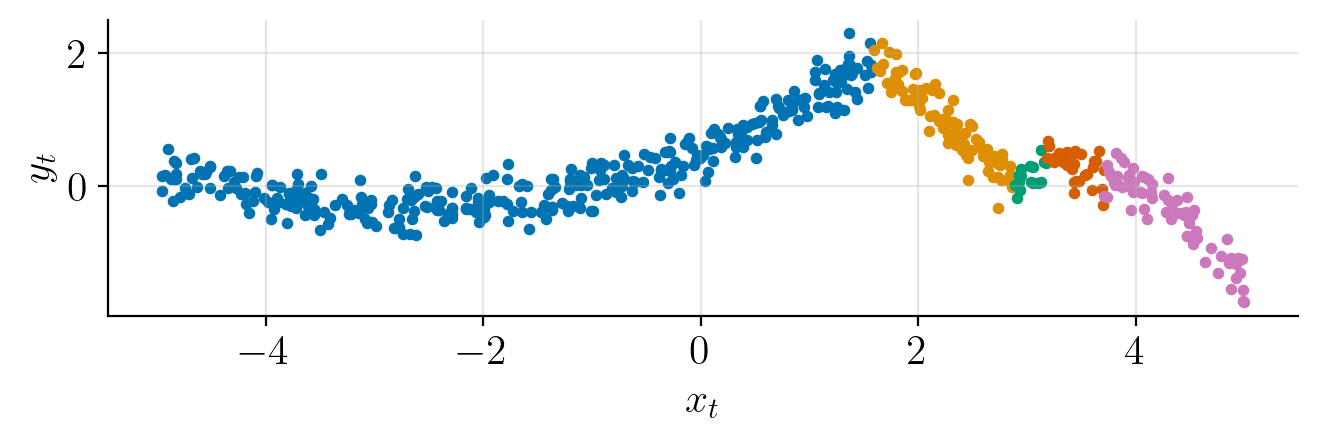

In [13]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))

colors = sns.color_palette()
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ymin, ymax = plt.ylim()
plt.grid(alpha=0.3)

## Building the measurment model

In [14]:
def build_features(x, last_x):
    delta = x - last_x
    phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
    return phi

def apply_fn(mean, x, bel):
    phi = build_features(x, bel.last_x)
    return mean @ phi

In [15]:
def callback(bel, bel_prior, y, X, ixs):
    log_posterior = bel_prior.log_joint - jax.nn.logsumexp(bel_prior.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)

    pred_values = jax.vmap(apply_fn, in_axes=(0, None, 0))(bel_prior.mean, X, bel_prior)
    pred = posterior @ pred_values

    Ht = build_features(X, bel_prior.last_x)
    var_pred = jnp.einsum("nk,knm,mk,k->", Ht, bel_prior.cov, Ht, posterior)
    var_pred = var_pred + std_measurements ** 2
    
    out = {
        "log_joint": bel.log_joint,
        "runlength": bel.runlength,
        "ixs": ixs,
        "err": pred - y,
        "yhat": pred,
        "yhat_var": var_pred,
    }
    return out

## RL with moment matching

In [16]:
filter = ExtendedKalmanFilterFeatures(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=std_measurements ** 2
)
p_change = 0.01
afilter = PiecewiseRLPR(p_change, K=1, filter=filter, moment_match=True)

In [17]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_mm = afilter.scan(y[:, None], x[:, None], bel_init, callback)

In [18]:
log_posterior = hist_mm["log_joint"] - jax.nn.logsumexp(hist_mm["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [19]:
jnp.sqrt(jnp.power(hist_mm["err"], 2).mean())

Array(0.45395893, dtype=float32)

In [20]:
hist_mm["yhat_var"].shape

(560,)

In [21]:
ymin_mm = hist_mm["yhat"].squeeze() - 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())
ymax_mm = hist_mm["yhat"].squeeze() + 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())

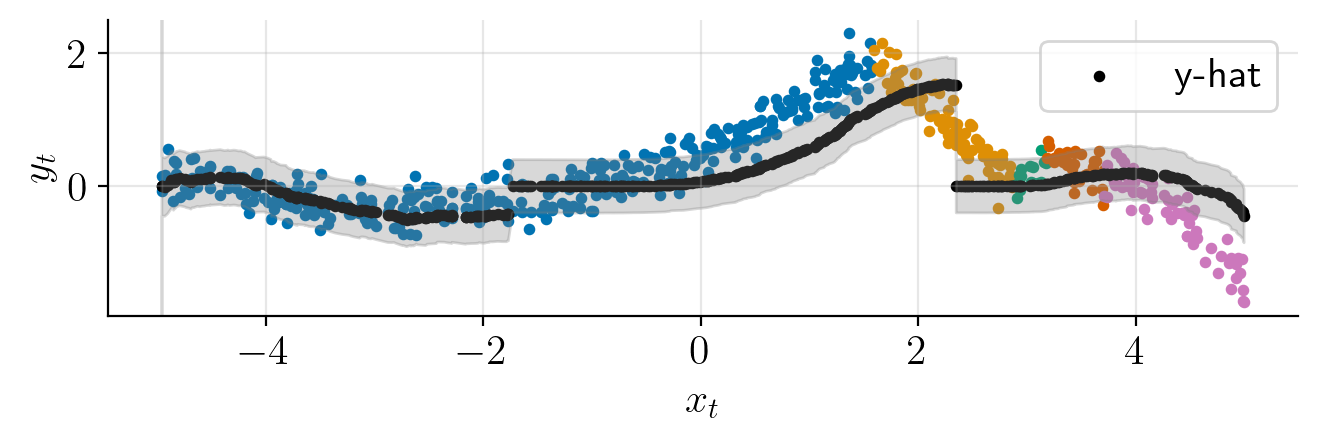

In [22]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_mm["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

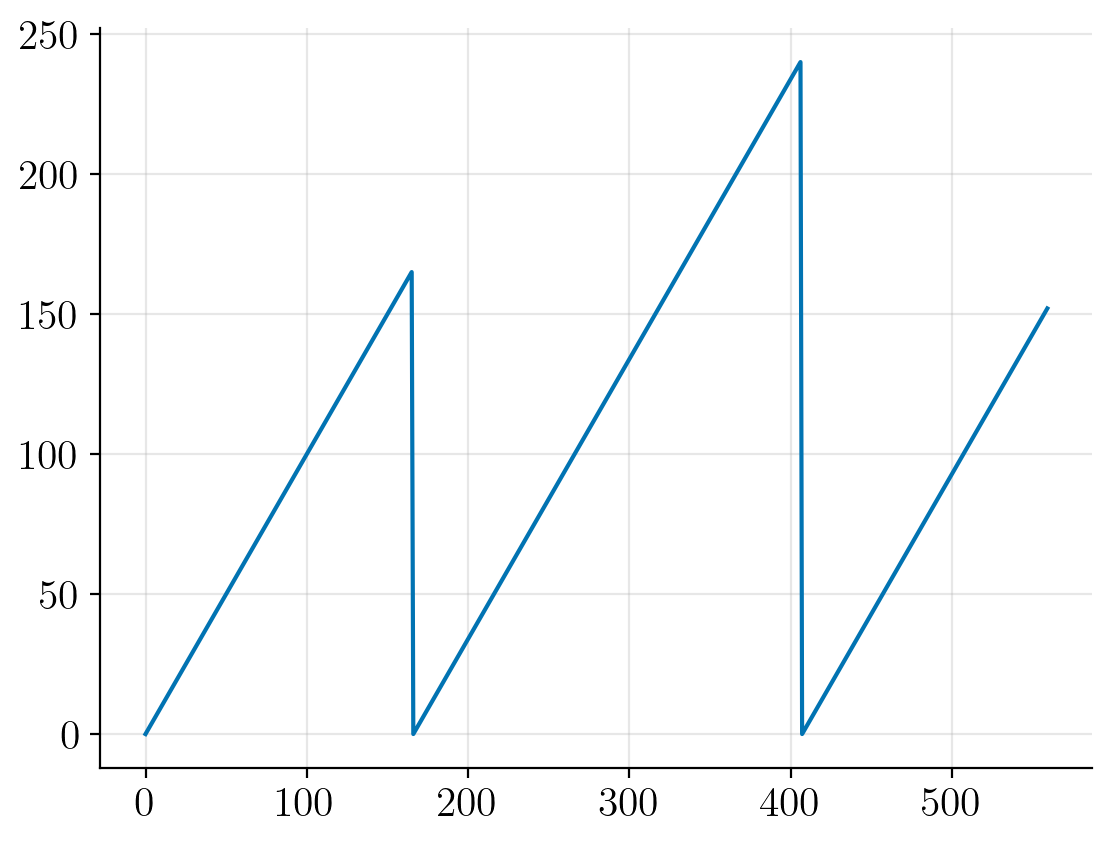

In [23]:
expected_runlength_rlmmpr = jnp.einsum("tk,tk->t", hist_mm["runlength"], posterior)
plt.plot(expected_runlength_rlmmpr)
plt.grid(alpha=0.3)

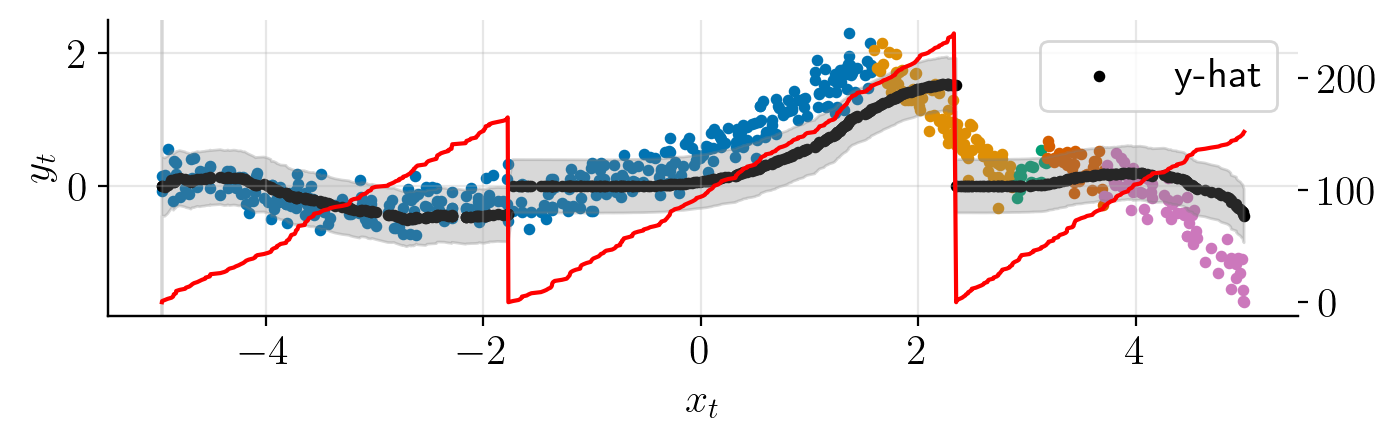

In [24]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_mm["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlmmpr, c="red")

## RL without moment-matching

In [25]:
filter = ExtendedKalmanFilterFeatures(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=0.2 ** 2
)
p_change = 0.01
afilter = PiecewiseRLPR(p_change, K=1, filter=filter, moment_match=False)

In [26]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_rlpr = afilter.scan(y[:, None], x[:, None], bel_init, callback)

In [27]:
log_posterior = hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [28]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(0.8624169, dtype=float32)

In [29]:
ymin_rlpr = hist_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())

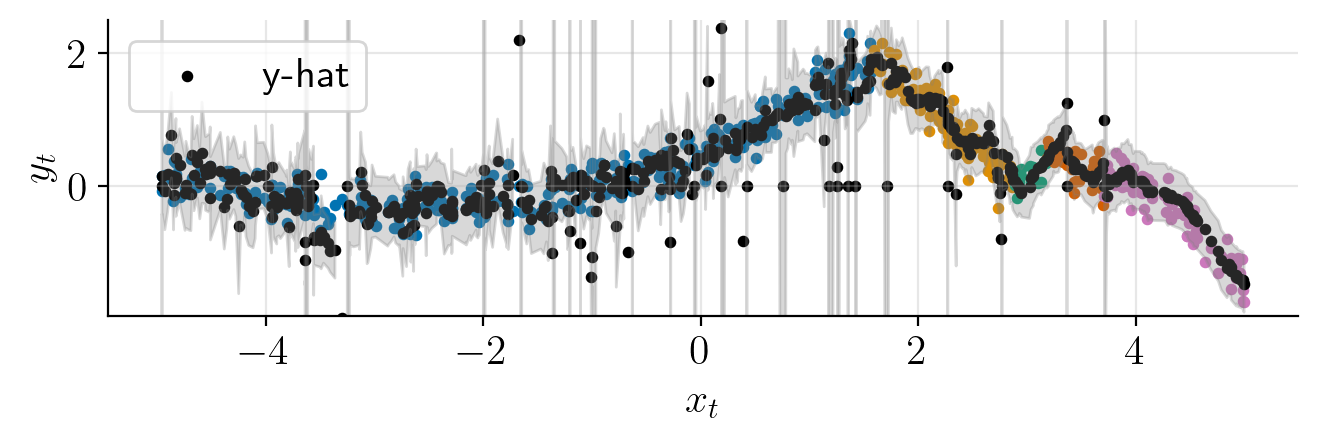

In [30]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_rlpr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

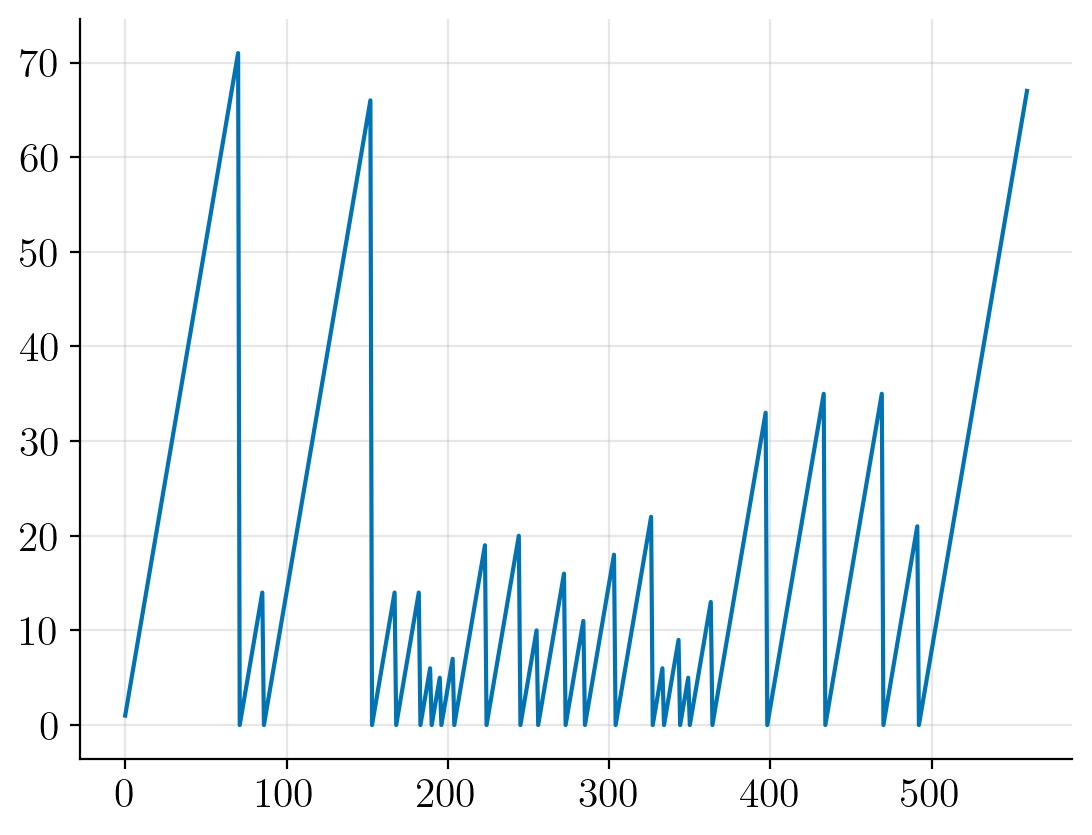

In [31]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_rlpr["runlength"], posterior)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

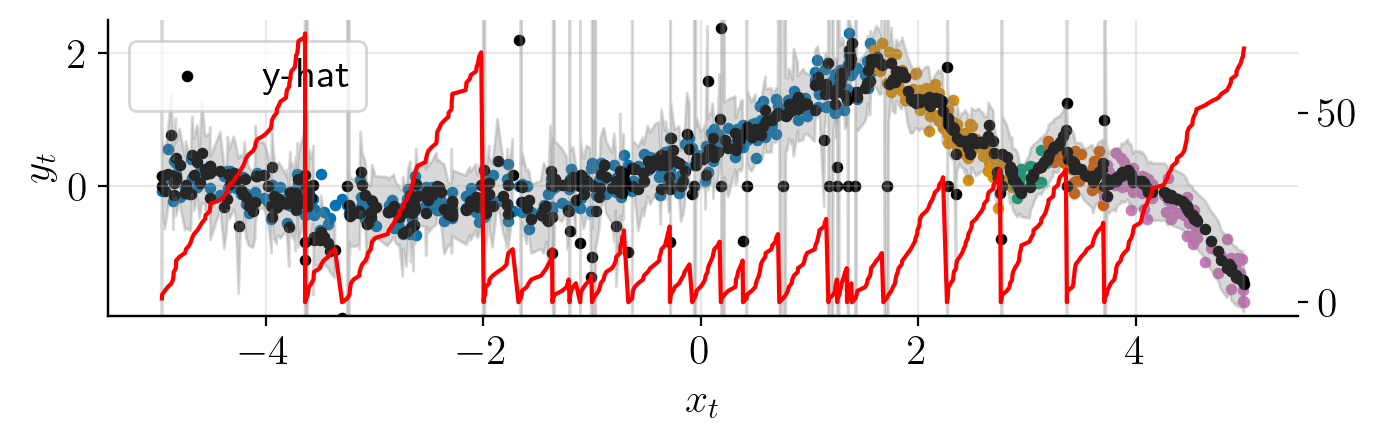

In [32]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_rlpr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlpr, c="red")

## Soft-prior reset

In [33]:
filter = ExtendedKalmanFilterFeatures(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=0.2 ** 2
)
p_change = 0.01
sfilter = SoftPiecewiseRLPR(p_change, filter=filter, deflate_mean=True, threshold=0.001)

In [34]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = sfilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_spr = sfilter.scan(y[:, None], x[:, None], bel_init, callback)

In [35]:
ymin_spr = hist_spr["yhat"].squeeze() - 2 * jnp.sqrt(hist_spr["yhat_var"].squeeze())
ymax_spr = hist_spr["yhat"].squeeze() + 2 * jnp.sqrt(hist_spr["yhat_var"].squeeze())

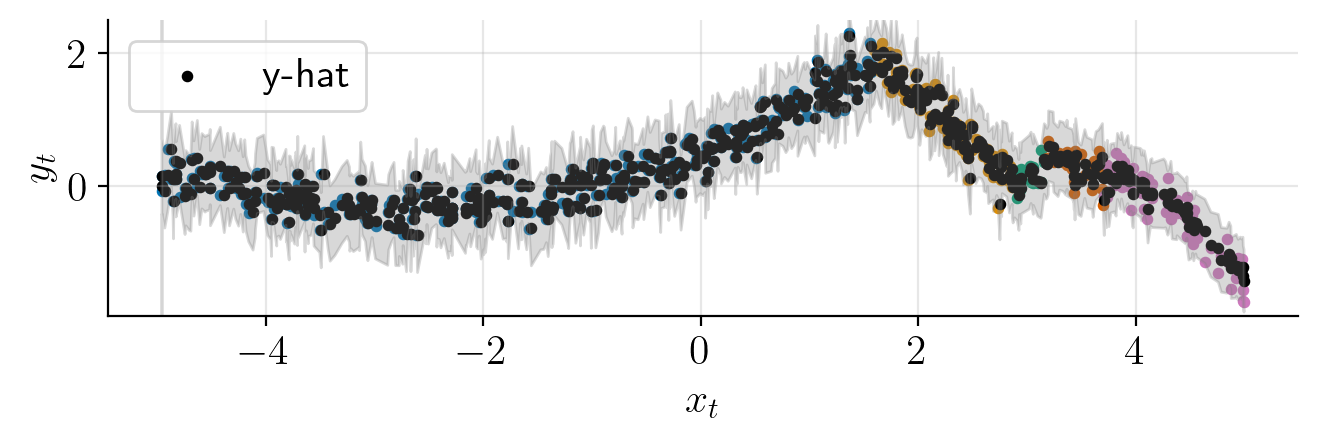

In [36]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_spr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

In [37]:
jnp.sqrt(jnp.power(hist_spr["err"], 2).mean())

Array(0.27549142, dtype=float32)

In [38]:
log_posterior = hist_spr["log_joint"] - jax.nn.logsumexp(hist_spr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

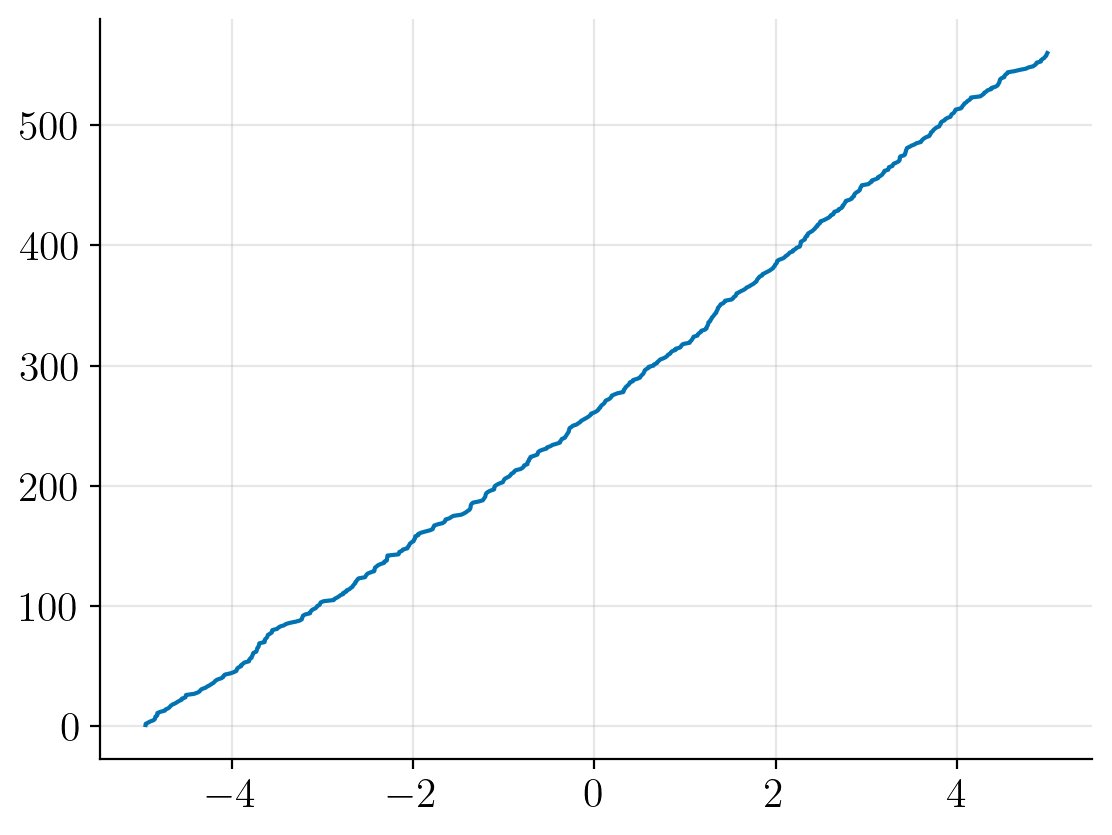

In [39]:
expected_runlength_rlspr = jnp.einsum("tk,tk->t", hist_spr["runlength"], posterior)
plt.plot(x, expected_runlength_rlspr)
plt.grid(alpha=0.3)

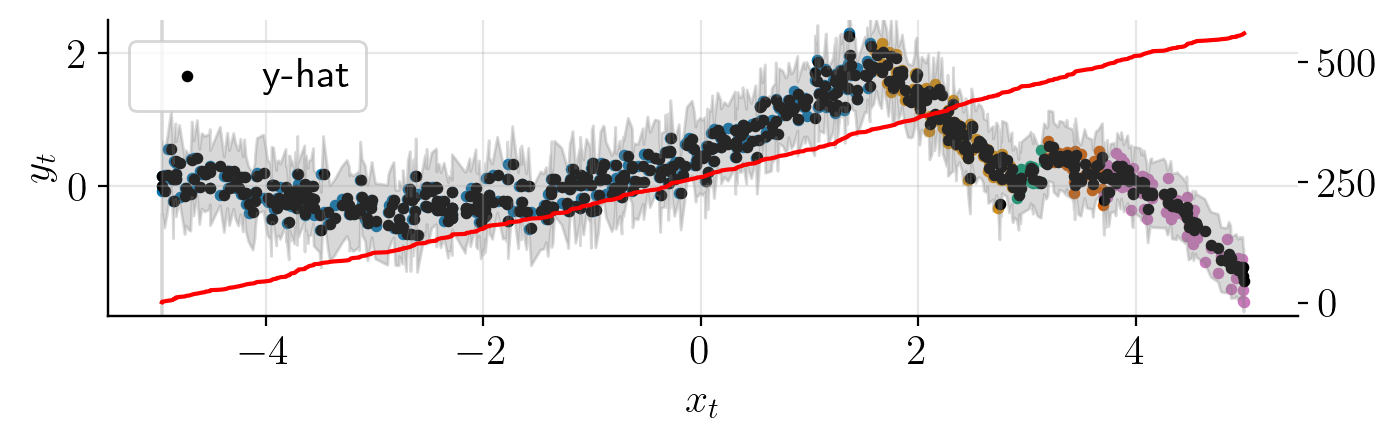

In [40]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_spr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlspr, c="red")

## Comparison plot

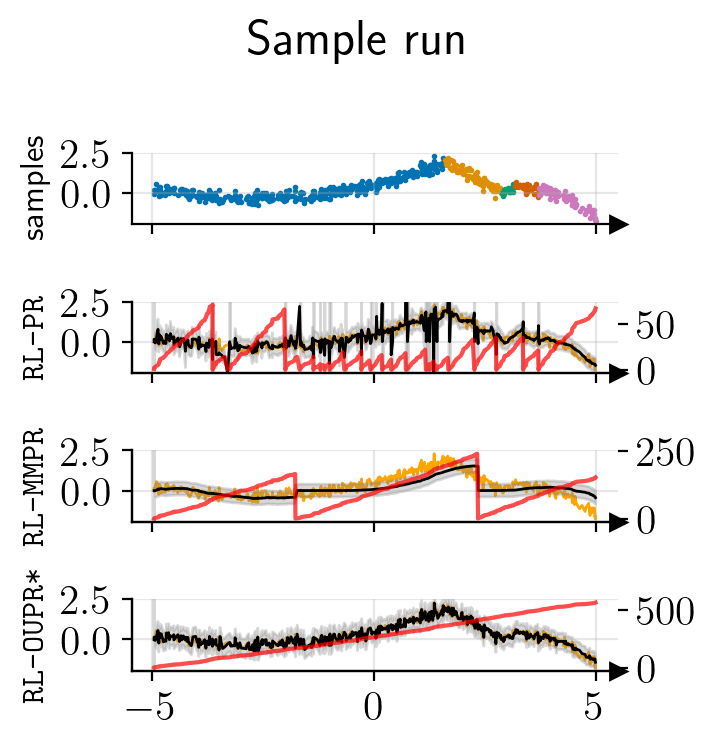

In [41]:
fig, axs = plt.subplots(4, 1, figsize=(6.4 * 1.2 * 0.5, 4.8 * 0.8), sharey=True, sharex=True)

markersize = 1
axs = axs.ravel()
plt.sca(axs[0])
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=markersize)

plt.sca(axs[1])
# plt.scatter(x, hist_rlpr["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_rlpr["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)
ax2 = axs[1].twinx()
ax2.plot(x, expected_runlength_rlpr, c="red", alpha=0.7)

plt.sca(axs[2])
# plt.scatter(x, hist_mm["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_mm["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)
ax2 = axs[2].twinx()
ax2.plot(x, expected_runlength_rlmmpr, c="red", alpha=0.7)

ax = axs[3]
plt.sca(axs[3])
# ax.scatter(x, hist_spr["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_spr["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)

ax2 = axs[3].twinx()
ax2.plot(x, expected_runlength_rlspr, c="red", alpha=0.7)

titles = ["samples", r"$\texttt{RL-PR}$", r"$\texttt{RL-MMPR}$", r"$\texttt{RL-OUPR*}$"]
for ax, title in zip(axs, titles):
    ax.grid(alpha=0.3)
    color_text = "black"
    # if "samples" in title:
    #     color_text = "black"
    # elif "SPR" in title:
    #     color_text = "teal"
    # else:
    #     color_text = "crimson"
    
    ax.set_ylabel(title, color=color_text, fontsize=12)

plt.tight_layout()
# plt.xlabel("$x_t$")
xmin, xmax = plt.xlim()

for i, ax in enumerate(axs):
    if i > 0:
        ax.plot(x, y, c="orange", linewidth=1.0, zorder=0)
    ax.plot(xmax, ymin, ">k", clip_on=False)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)

plt.suptitle("Sample run")
plt.tight_layout()
plt.savefig(f"../figures/segment-dependency-sample.png", dpi=300, bbox_inches="tight")

## Multiple runs

In [42]:
key = jax.random.PRNGKey(314)
key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

In [43]:
p = 0.01
n_partitions = 5
partitions = sample_partitions(key_partition, p, n_partitions)
n_samples = partitions[-1]
x = sample_covariates(key_x, n_samples)
y = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=0.2, n_power=3)
pair_partitions = list(zip(partitions[:-1], partitions[1:]))

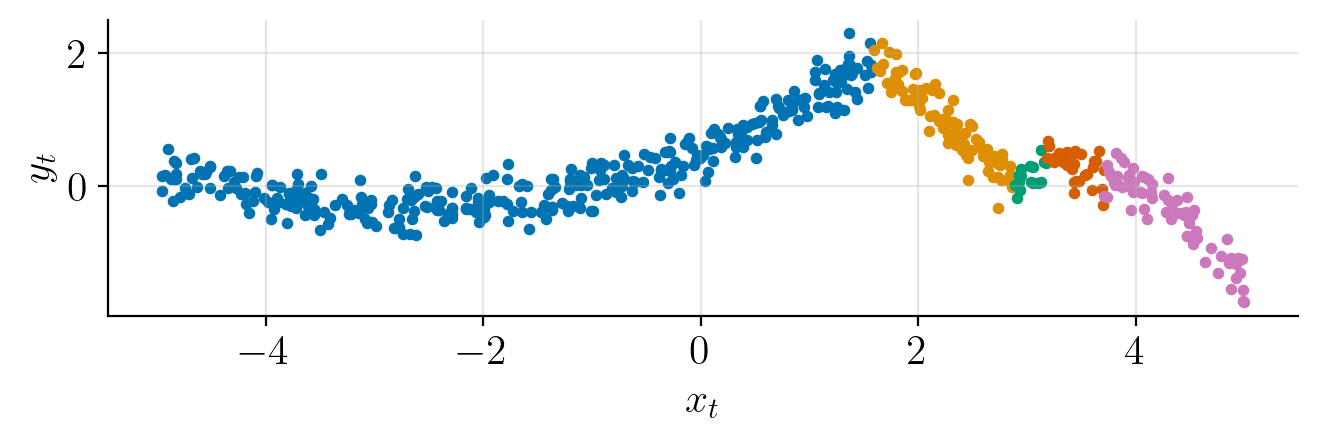

In [44]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))

colors = sns.color_palette()
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ymin, ymax = plt.ylim()
plt.grid(alpha=0.3)

In [45]:
@jax.jit
def filter_cst(y, x, obs_variance):
    def apply_fn(mean, x):
        delta = x - x[-1]
        phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
        return mean @ phi

    def callback(bel, bel_prior, y, X):
        pred = apply_fn(bel_prior.mean, X)
        
        out = {
            "err": pred - y,
            "yhat": pred
        }
        return out
        
    filter = ExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0

    bel_init = filter.init_bel(mean, cov)
    bel_final, hist = filter.scan(bel_init, y[:, None], x[:, None], callback)
    return hist


@jax.jit
def filter_rlpr(y, x, p_change, obs_variance, K=1):
    filter = ExtendedKalmanFilterFeatures(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = PiecewiseRLPR(p_change, K=K, filter=filter, moment_match=False)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


@jax.jit
def filter_rlmmpr(y, x, p_change, obs_variance, K=1):
    filter = ExtendedKalmanFilterFeatures(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = PiecewiseRLPR(p_change, K=K, filter=filter, moment_match=True)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


@jax.jit
def filter_rlspr(y, x, p_change, obs_variance, threshold):
    filter = ExtendedKalmanFilterFeatures(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = SoftPiecewiseRLPR(p_change, filter=filter, deflate_mean=True, threshold=threshold)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


In [46]:
p_change = 0.01
obs_variance = 0.2 ** 2

In [47]:
hist_static = filter_cst(y, x, obs_variance)
hist_rlpr = filter_rlpr(y, x, p_change, obs_variance)
hist_rlmmpr = filter_rlmmpr(y, x, p_change, obs_variance)
hist_rlspr = filter_rlspr(y, x, p_change, obs_variance, threshold=1/2)

In [48]:
jnp.sqrt(jnp.power(hist_static["err"], 2).mean())

Array(0.703442, dtype=float32)

In [49]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(0.8624169, dtype=float32)

In [50]:
jnp.sqrt(jnp.power(hist_rlmmpr["err"], 2).mean())

Array(0.45395893, dtype=float32)

In [51]:
jnp.sqrt(jnp.power(hist_rlspr["err"], 2).mean())

Array(0.27549142, dtype=float32)

## Multiple keys

In [55]:
p = 0.01
n_sims = 100
n_partitions = 5
key_init = jax.random.PRNGKey(314)
threshold = 1/2
errs = []
changepoints = []

for s in tqdm(range(n_sims)):
    key = jax.random.fold_in(key_init, s)
    key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

    partitions = sample_partitions(key_partition, p, n_partitions)
    n_samples = partitions[-1]
    x = sample_covariates(key_x, n_samples)
    y = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=0.2, n_power=3)
    pair_partitions = list(zip(partitions[:-1], partitions[1:]))


    hist_static = filter_cst(y, x, obs_variance)
    hist_rlpr = filter_rlpr(y, x, p_change, obs_variance)
    hist_rlmmpr = filter_rlmmpr(y, x, p_change, obs_variance)
    hist_rlspr = filter_rlspr(y, x, p_change, obs_variance, threshold)

    changepoints.append({
        "C-F": 0.0,
        "RL-PR": (hist_rlpr["runlength"] == 0).sum(),
        "RL-MMPR": (hist_rlmmpr["runlength"] == 0).sum(),
        "RL-OUPR": (hist_rlspr["runlength"] == 0).sum(),
    })

    errs.append({
        "C-F": jnp.sqrt(jnp.power(hist_static["err"], 2).mean()),
        "RL-PR": jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean()),
        "RL-MMPR": jnp.sqrt(jnp.power(hist_rlmmpr["err"], 2).mean()),
        "RL-OUPR": jnp.sqrt(jnp.power(hist_rlspr["err"], 2).mean()),
    })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.41s/it]


In [56]:
errs_df = jax.tree.map(np.array, errs)
errs_df = pd.DataFrame(errs)
errs_df = errs_df.rename({"RL-OUPR":"RL-OUPR*"}, axis=1)
errs_df = errs_df.astype(float)

In [57]:
count_df = jax.tree.map(np.array, changepoints)
count_df = pd.DataFrame(count_df).astype(int)
count_df = count_df.rename({"RL-SPR": "RL-OUPR*"}, axis=1)
count_df.describe()

,C-F,RL-MMPR,RL-OUPR,RL-PR
count,100.0,100.000000,100.000000,100.000000
mean,0.0,9.150000,1.510000,28.840000
std,0.0,11.137683,0.658971,10.761623
min,0.0,1.000000,0.000000,8.000000
25%,0.0,2.000000,1.000000,21.750000
50%,0.0,5.000000,2.000000,27.500000
75%,0.0,11.000000,2.000000,35.500000
max,0.0,61.000000,3.000000,59.000000


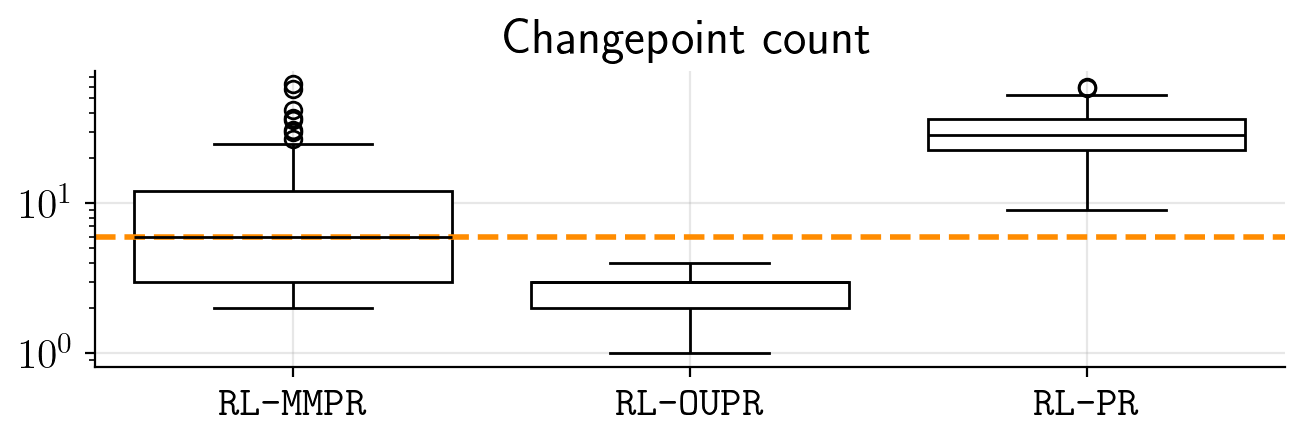

In [58]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))


sns.boxplot(
    x="variable",
    y="value",
    data=(count_df+1).drop("C-F", axis=1).melt(),
    color="white",
    linecolor="black",
)

pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)


plt.xlabel("")
plt.ylabel("")
plt.title("Changepoint count")
plt.yscale("log")
plt.axhline(y=6, c="darkorange", linestyle="--", linewidth=2)
plt.grid(alpha=0.3)
plt.savefig("../figures/segment-count.png", dpi=300, bbox_inches="tight")

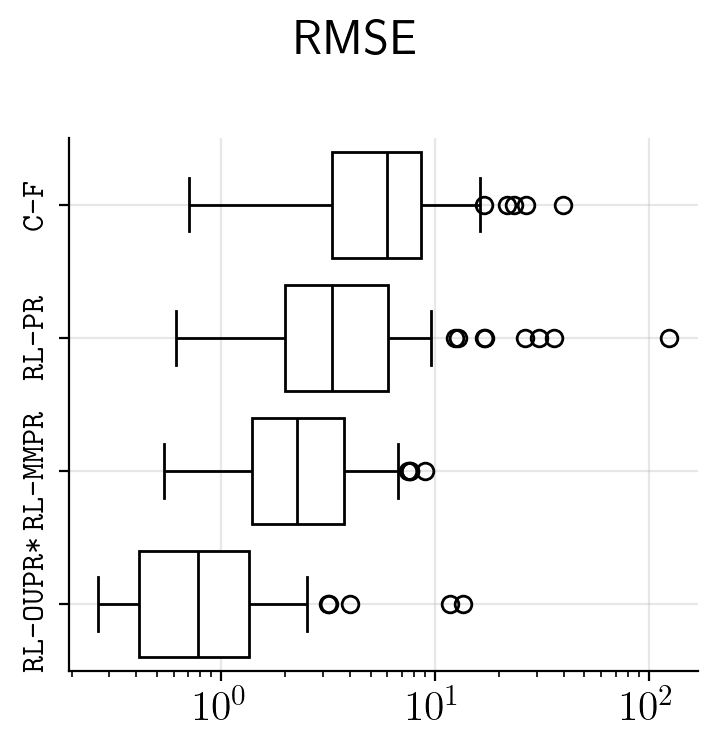

In [59]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2 * 0.5, 4.8 * 0.8))

sns.boxplot(
    y="variable",
    x="value",
    data=errs_df.rename({c: r"\texttt{" + c + "}" for c in errs_df}, axis=1).melt(),
    color="white",
    linecolor="black",
)

plt.grid(alpha=0.3)
plt.xscale("log")

pos, ticks = plt.yticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.yticks(pos, newlabels)


plt.yticks(rotation=90, fontsize=12, verticalalignment="center")
plt.suptitle("RMSE")
plt.yticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../figures/segment-dependency-result.png", dpi=300, bbox_inches="tight")

In [60]:
errs_df.describe()

,C-F,RL-PR,RL-MMPR,RL-OUPR*
count,100.000000,100.000000,100.000000,100.000000
mean,7.034700,6.085980,2.874580,1.199122
std,5.870077,13.269871,1.924163,1.794032
min,0.708596,0.616285,0.539419,0.264254
25%,3.301319,1.992488,1.400688,0.413816
50%,5.987443,3.309536,2.267536,0.779367
75%,8.624866,6.062928,3.766656,1.353384
max,39.739616,125.024460,9.020914,13.567896
